In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os 
import glob
from time import time
from nltk.stem import PorterStemmer, WordNetLemmatizer
#import nlp tools
import nltk, string,re
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import PorterStemmer, WordNetLemmatizer
import gensim
import pickle

# Building the Car Review Dataframe

In [ ]:
#Loading all the car review CSV and concantenating them into a single dataframe.

path = r'/Users/matttom/Desktop/NLP Project 4/car-reviews'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent


df_from_each_file = (pd.read_csv(f,lineterminator='\n',index_col=0) for f in all_files)
concatenated_df  = pd.concat(df_from_each_file, ignore_index=True)
# doesn't create a list, nor does it append to one



In [ ]:
#Filtering the dataframe to capture only car years > 2010.
concatenated_df.Review_Date = concatenated_df.Vehicle_Title.apply(lambda x:x.split()[0])
concatenated_df.Review_Date = concatenated_df.Review_Date.apply(lambda x:pd.to_datetime(x))
concatenated_df['year'] = concatenated_df.Review_Date.dt.year
concatenated_df = concatenated_df[concatenated_df.year > 2010]

In [ ]:
concatenated_df.shape

In [ ]:
#Dropping the unncessary columns 
car_df = concatenated_df.drop(columns=['Review_Date','Author_Name','Review_Title','year'],axis=1)

#Renaming all the columns of the dataframe.
car_df.rename(columns={'Vehicle_Title':'vehicle','Review':'review','Rating\r':'rating'},inplace=True)


In [ ]:
car_df.reset_index(drop=True, inplace=True)
car_df.head()

In [ ]:
#saving final dataframe as pickle file

with open('car_df', 'wb') as f: #change
    pickle.dump(car_df, f)         #change 
    

# Cleaning the Car Review Dataframe

In [4]:
#Loading the pickled car dataframe
with open('car_df', 'rb') as f:
    car_df = pickle.load(f)

In [5]:
car_df.head()

,vehicle,review,rating
0,2013 Volkswagen Eos Convertible Komfort SULEV ...,Fun to drive with lots of amenities,5.000
1,2015 Volkswagen Eos Convertible Final Edition ...,Worth searching and waiting to the perfect fit,5.000
2,2011 Volkswagen Eos Convertible Lux SULEV 2dr ...,I bought this car used and I love it. A deca...,5.000
3,2014 Volkswagen Eos Convertible Komfort 2dr Co...,great value for a hardtop convertible,4.000
4,2014 Volkswagen Eos Convertible Executive 2dr ...,It is a beautiful understated car that get's ...,4.125


In [6]:
#Round ratings into whole numbers
car_df.rating = car_df.rating.apply(lambda x : np.round(x))

In [7]:
#Creating a text_length feature
car_df['text_length'] = car_df['review'].apply(lambda x:len(x.split()))

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


rating
1.0    167.525850
2.0    162.645948
3.0    156.854260
4.0    139.857474
5.0    118.393449
Name: text_length, dtype: float64

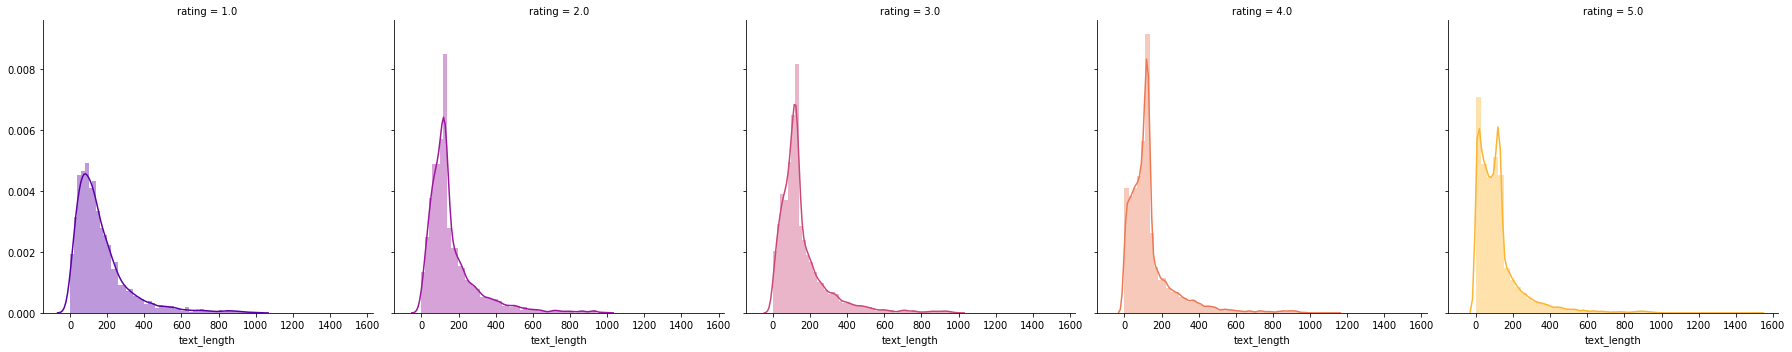

In [8]:
a = sns.FacetGrid(data = car_df, col = 'rating', hue = 'rating', palette='plasma', size=5)
a.map(sns.distplot, "text_length")
car_df.groupby('rating').mean()['text_length']

Looks like there is a relationship with the amount of text in a review vs. the rating of the particular car.

## Cleaning the reviews

Creating helper functions to clean the data

In [9]:
def lem(x):
    '''Lemmatizing the words'''
    lem = WordNetLemmatizer()
    lemma = [lem.lemmatize(t) for t in x]
    return lemma

def clean_text(x):
    '''Removing any punctuations'''
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_text2(x):
    '''Removing any words that are less than 3 letters'''
    pattern = r'\b\w{1,3}\b'
    text = re.sub(pattern,'',x)
    return x

def clean_numbers(x):
    '''More cleaning done'''
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '', x)
        x = re.sub('[0-9]{4}', '', x)
        x = re.sub('[0-9]{3}', '', x)
        x = re.sub('[0-9]{2}', '', x)
    return x

def lc_remove(text):
    '''Removing documents that are less than 3 words '''
    return ' '.join(word for word in text.split() if len(word)>3)

def removepunc(x):
    '''Removing punctuations'''
    return re.sub('[%s]' % re.escape(string.punctuation), ' ', x)

stop = stopwords.words('english');
stop.append('good')
stop.append('vehicle')
stop.append('great')
stop.append('ride')

In [10]:
car_df.review = car_df.review.apply(lambda x:removepunc(x))
car_df.review = car_df.review.str.lower().str.split()
car_df.review = car_df.review.apply(lambda x:[item for item in x if item not in stop])
car_df.review = car_df.review.apply(lambda x:[item for item in x if not item.isdigit()]);
car_df.review = car_df.review.apply(lambda x:lem(x))

In [11]:
car_df['review']=[" ".join(review) for review in car_df['review'].values]
car_df.review = car_df.review.apply(lambda x:clean_text(x))
car_df.review = car_df.review.apply(lambda x:clean_text2(x))
car_df['review'] = car_df['review'].apply(lambda x:clean_numbers(x))
car_df.review = car_df.review.apply(lambda x:gensim.utils.simple_preprocess(x))

In [12]:
car_df['text_length'] = car_df['review'].apply(lambda x:len(x))
car_df = car_df[car_df.text_length > 6]
car_df.reset_index(inplace=True,drop=True)

In [13]:
#Joining all the words in the review back to a string text.
car_df['review']=[" ".join(review) for review in car_df['review'].values]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


rating
1.0    82.048410
2.0    79.954041
3.0    78.304915
4.0    72.649907
5.0    64.751406
Name: text_length, dtype: float64

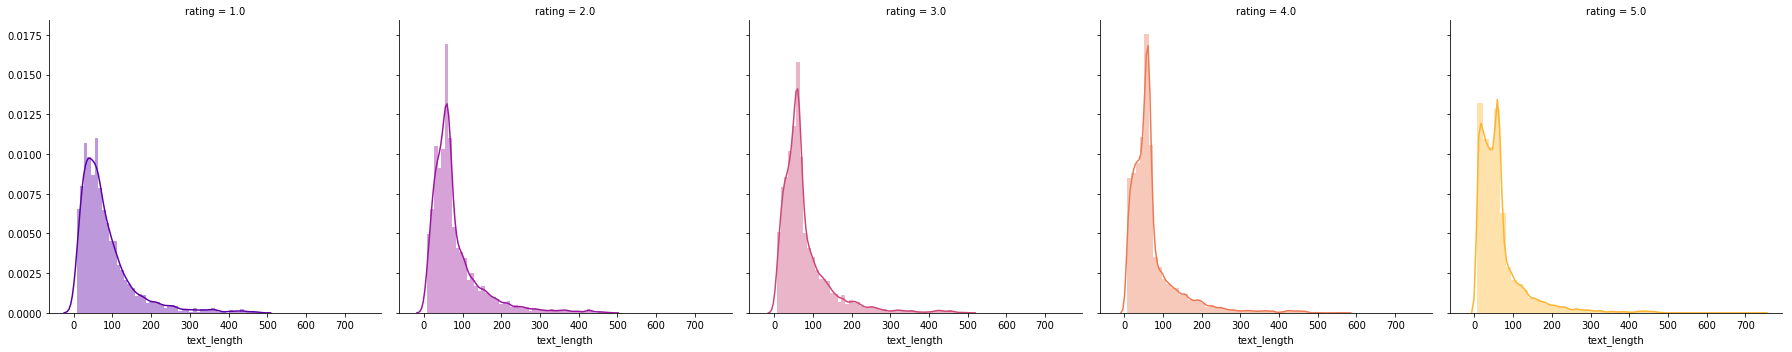

In [14]:
a = sns.FacetGrid(data = car_df, col = 'rating', hue = 'rating', palette='plasma', size=5)
a.map(sns.distplot, "text_length")
car_df.groupby('rating').mean()['text_length']

New text lengths after applying some data pre-processing on the corupus

In [25]:
with open('car_df_cleaned', 'wb') as f: #change
    pickle.dump(car_df, f)         #change 